In [106]:
bucket = 'arch-ml-bucket-us-east-1'
prefix = 'mall_customer'

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
import os
import pandas as pd
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
role = get_execution_role()

# Data Preprocessing

In [3]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.shape

(200, 5)

In [5]:
features = ['Annual Income (k$)', 'Spending Score (1-100)']
train_df = df[features]

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
train_df = pd.DataFrame(data=train_df, columns=features)
train_df = train_df.astype('float32')

In [7]:
train_df.to_csv('train.csv', header=False, index=False)

In [8]:
# Write Column List

with open('feature_list.txt','w') as f:
    f.write(','.join(features))

In [9]:
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(obj=scaler, file=f)    

# Upload data to S3

In [10]:
def write_to_s3(filename):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket)\
            .Object(os.path.join(prefix, filename)).upload_fileobj(f)

In [11]:
write_to_s3('train.csv')

# Train

In [12]:
container = get_image_uri(boto3.Session().region_name, 'kmeans')

In [13]:
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:1'

In [14]:
# https://aws.amazon.com/blogs/machine-learning/k-means-clustering-with-amazon-sagemaker/

K = range(2, 12) # start from '1 cluster' does not make sense
INSTANCE_COUNT = 1
run_parallel_jobs = True
instance_type = 'ml.m4.xlarge'
feature_dim = 2
job_names = []
base_job_name = 'kmeans-mall-v2'
train_data_path = 's3://{}/{}/{}'.format(bucket, prefix, 'train.csv')

for k in K:
    print('starting train job:' + str(k))

    output_path = 's3://{}/{}/{}'.format(bucket, prefix, base_job_name)    
    print('training artifacts will be uploaded to: {}'.format(output_path))    
    
    base_j_name = '{}-clusters-{}'.format(k, base_job_name)
    sess = sagemaker.Session()    
    estimator = sagemaker.estimator.Estimator(container,
                                              role, 
                                              train_instance_count=INSTANCE_COUNT, 
                                              train_instance_type=instance_type,
                                              output_path=output_path,
                                              sagemaker_session=sess,
                                              base_job_name=base_j_name)

    estimator.set_hyperparameters(k=k, feature_dim=feature_dim)

    s3_data = train_data_path
    training_input_config = sagemaker.session.s3_input(s3_data=s3_data, content_type="text/csv;label_size=0")

    estimator.fit({'train':training_input_config}, wait=False)
    
    boto3_sagemaker = boto3.client('sagemaker')
    job_name = estimator.latest_training_job.name
    
    status = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)
    
    if not run_parallel_jobs:
        try:
            boto3_sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
        finally:
            status = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
            print("Training job ended with status: " + status)
            if status == 'Failed':
                message = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
                print('Training failed with the following error: {}'.format(message))
                raise Exception('Training job failed')
    
    job_names.append(job_name)

INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-2-2019-05-07-14-56-10-137


starting train job:2
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-3-2019-05-07-14-56-10-504


InProgress
starting train job:3
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-4-2019-05-07-14-56-10-825


InProgress
starting train job:4
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-5-2019-05-07-14-56-20-892


InProgress
starting train job:5
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-6-2019-05-07-14-56-21-228


InProgress
starting train job:6
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-7-2019-05-07-14-56-21-526


InProgress
starting train job:7
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-8-2019-05-07-14-56-22-712


InProgress
starting train job:8
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-9-2019-05-07-14-56-23-114


InProgress
starting train job:9
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-10-2019-05-07-14-56-23-410


InProgress
starting train job:10
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer


INFO:sagemaker:Creating training-job with name: kmeans-mall-v2-clusters-11-2019-05-07-14-56-30-307


InProgress
starting train job:11
training artifacts will be uploaded to: s3://arch-ml-bucket-us-east-1/mall_customer
InProgress


In [ ]:
while len(job_names):
    boto3_sagemaker = boto3.client('sagemaker')
    try:
        boto3_sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_names[0])
    finally:
        status = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
        print("Training job ended with status: " + status)
        if status == 'Failed':
            message = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
            print('Training failed with the following error: {}'.format(message))
            raise Exception('Training job failed')

    print(job_name)

    info = boto3_sagemaker.describe_training_job(TrainingJobName=job_name)
    job_names.pop(0)

In [65]:
def list_s3_items_keys():
    client = boto3.client('s3')
    items = client.list_objects(Bucket=bucket, Prefix=prefix)['Contents']
    return list(map(lambda x: x['Key'], items))

In [98]:
def filter_model_keys():
    keys = list_s3_items_keys()
    
    filtered = []
    for key in keys:
        path = key.replace(prefix + '/', '')
        if path.startswith(base_job_name):
            filtered.append(key)
        
    return filtered

Model for k=2 (mall_customer/kmeans-mall-v2-clusters-2-2019-05-07-14-56-10-137/output/model.tar.gz)
model_algo-1
state_7803ff0f-30e3-4726-9616-65b6d0fbbadf
Model for k=3 (mall_customer/kmeans-mall-v2-clusters-3-2019-05-07-14-56-10-504/output/model.tar.gz)
state_06c80c92-da0e-4010-a8ad-09f33aa77705
model_algo-1
Model for k=4 (mall_customer/kmeans-mall-v2-clusters-4-2019-05-07-14-56-10-825/output/model.tar.gz)
state_b890e518-57a1-4387-aec3-b5ebffc23563
model_algo-1
Model for k=5 (mall_customer/kmeans-mall-v2-clusters-5-2019-05-07-14-56-20-892/output/model.tar.gz)
state_28b8a004-e1eb-4e2b-aa05-ae75ad704785
model_algo-1
Model for k=6 (mall_customer/kmeans-mall-v2-clusters-6-2019-05-07-14-56-21-228/output/model.tar.gz)
model_algo-1
state_a7f1de59-6d4e-464f-95b2-6887526c1030
Model for k=7 (mall_customer/kmeans-mall-v2-clusters-7-2019-05-07-14-56-21-526/output/model.tar.gz)
model_algo-1
state_dd54e656-281b-46ea-975e-0dab7da0c286
Model for k=8 (mall_customer/kmeans-mall-v2-clusters-8-2019-05-0

Text(0.5,0,'k')

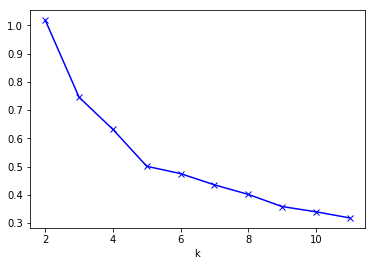

In [109]:
plt.plot()
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']
models = {}
distortions = []
for i, folder in enumerate([\
    'mall_customer/kmeans-mall-v2-clusters-2-2019-05-07-14-56-10-137',
    'mall_customer/kmeans-mall-v2-clusters-3-2019-05-07-14-56-10-504',
    'mall_customer/kmeans-mall-v2-clusters-4-2019-05-07-14-56-10-825',
    'mall_customer/kmeans-mall-v2-clusters-5-2019-05-07-14-56-20-892',
    'mall_customer/kmeans-mall-v2-clusters-6-2019-05-07-14-56-21-228',
    'mall_customer/kmeans-mall-v2-clusters-7-2019-05-07-14-56-21-526',
    'mall_customer/kmeans-mall-v2-clusters-8-2019-05-07-14-56-22-712',
    'mall_customer/kmeans-mall-v2-clusters-9-2019-05-07-14-56-23-114',
    'mall_customer/kmeans-mall-v2-clusters-10-2019-05-07-14-56-23-410',
    'mall_customer/kmeans-mall-v2-clusters-11-2019-05-07-14-56-30-307',
]):
    k = i + 2
    s3_client = boto3.client('s3')
    key = folder + '/output/model.tar.gz'
    s3_client.download_file(bucket, key, 'model.tar.gz')
    print("Model for k={} ({})".format(k, key))
    !tar -xvf model.tar.gz                       
    kmeans_model=mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortions.append(sum(np.min(cdist(train_df, kmeans_numpy, 'euclidean'), axis=1)) / train_df.shape[0])
    models[k] = kmeans_numpy
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')

# So the optimal number of clusters = 5

### we can then deploy that specific model to endpoint for future predictions (i.e. clustering)